# Pothole Detection

In [21]:
import tensorflow
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os


for dirname, _, filenames in os.walk(r'A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/normal\1.jpg
A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/normal\10.jpg
A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/normal\100.jpg
A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/normal\101.jpg
A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/normal\102.jpg
A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/normal\103.jpg
A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/normal\104.jpg
A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/normal\105.jpg
A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/normal\106.jpg
A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/normal\107.jpg
A:/TechieYan projects/A

## Importing all the required libraries

In [22]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import keras.preprocessing.image as img
from tensorflow.keras.applications.resnet50 import ResNet50

## Dataset is divided into two parts : test & train
### Both the directories (test and train) are divided further : Plain & Pothole

In [23]:
os.listdir('A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/')

['normal', 'potholes']

Resizing the images into (256 * 256) 

In [24]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass
        
def assign_label(img,label):
    return label

In [25]:
X=[]
Z=[]
IMG_SIZE=256
Plain=r'A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/normal'
Pothole=r'A:/TechieYan projects/AI/Pothole-Detection-master/Pothole-Detection-master/dataset/potholes'

make_train_data('Plain',Plain)
make_train_data('Pothole',Pothole)

100%|██████████| 329/329 [00:11<00:00, 28.57it/s]


## Displaying the training data with labels

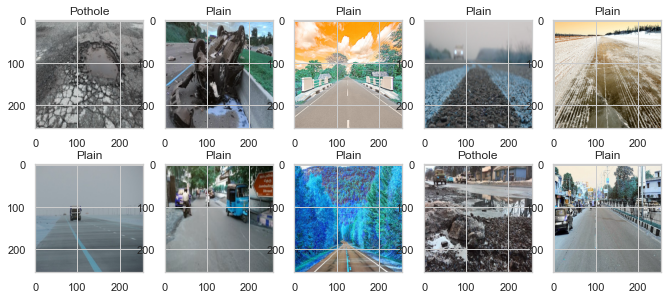

In [26]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

## Splitting the data into Training and Validation data

In [27]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
print(Y)
X=np.array(X)

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=1337)

np.random.seed(42)
rn.seed(42)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


# Building the CNN model using RESNET (pretrained model)

In [28]:
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(256,256,3), pooling='max')
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [29]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.20))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [30]:
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
base_model.trainable=True # setting the VGG model to be trainable.
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 30,408,066
Trainable params: 30,354,946


In [ ]:
History = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test))

## Saving the trained model

In [ ]:
model.save('A:\TechieYan projects\AI\Pothole_using_resnet50\model\model.h5')


## Model Accuracy

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## Model Loss

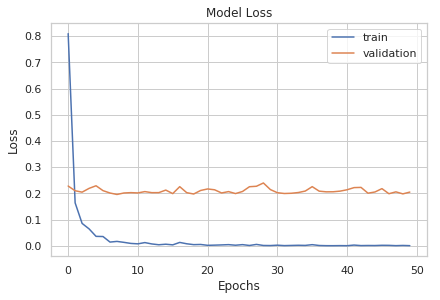

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Testing the trained model 
### [0,1] --> Pothole road
### [1,0] --> Plain road

### Testing the trained model on Pothole images

In [ ]:
path = "A:/TechieYan projects/AI/Pothole_using_resnet50/dataset/test_pot_images"
files = os.listdir(path)
files

['4.jpg', '5.jpg', '8.jpg', '1.jpg', '6.jpg', '3.jpg', '2.jpg', '7.jpg']

  0%|          | 0/8 [00:00<?, ?it/s]

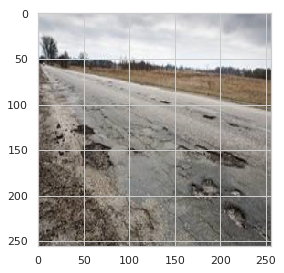

 12%|█▎        | 1/8 [00:03<00:27,  3.90s/it]

Pothole Road


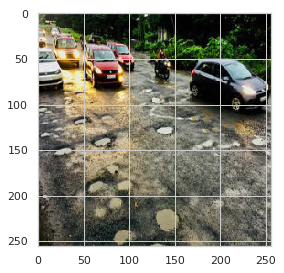

 25%|██▌       | 2/8 [00:04<00:16,  2.79s/it]

Pothole Road


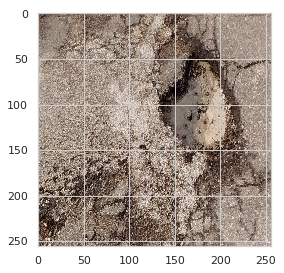

 38%|███▊      | 3/8 [00:04<00:10,  2.02s/it]

Pothole Road


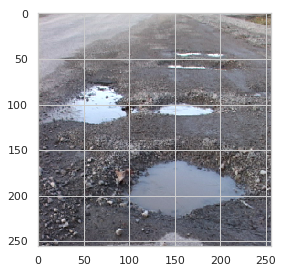

 50%|█████     | 4/8 [00:04<00:05,  1.48s/it]

Pothole Road


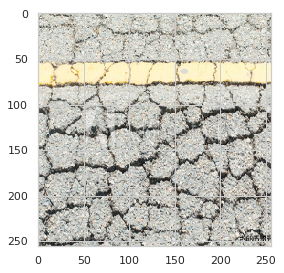

 62%|██████▎   | 5/8 [00:04<00:03,  1.09s/it]

Pothole Road


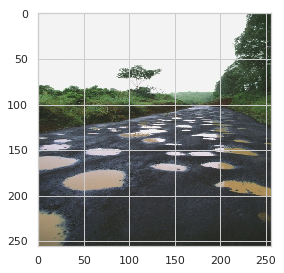

 75%|███████▌  | 6/8 [00:04<00:01,  1.21it/s]

Pothole Road


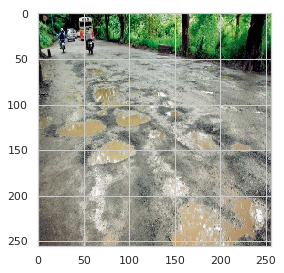

 88%|████████▊ | 7/8 [00:05<00:00,  1.58it/s]

Pothole Road


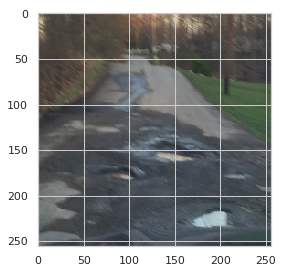

100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

Pothole Road


In [ ]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1]) 
    plt.show()  

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Plain Road")
    else:
        print("Pothole Road")

### Testing the trained model on Plain images

In [ ]:
path = "A:/TechieYan projects/AI/Pothole_using_resnet50/dataset/test_norm_images"
files = os.listdir(path)
files

['4.jpg', '5.jpg', '8.jpg', '1.jpg', '6.jpg', '3.jpg', '2.jpg', '7.jpg']

  0%|          | 0/8 [00:00<?, ?it/s]

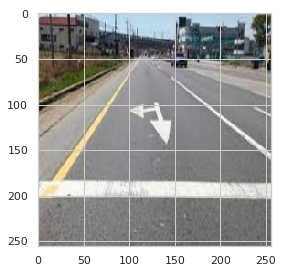

 12%|█▎        | 1/8 [00:00<00:01,  4.02it/s]

Plain Road


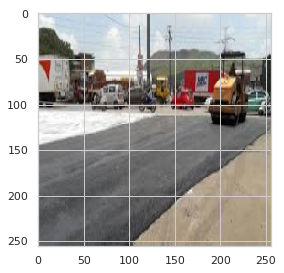

 25%|██▌       | 2/8 [00:00<00:01,  3.79it/s]

Pothole Road


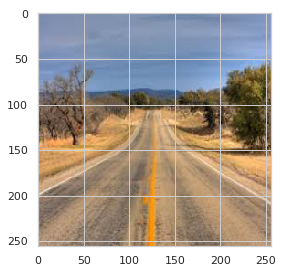

 38%|███▊      | 3/8 [00:00<00:01,  3.53it/s]

Plain Road


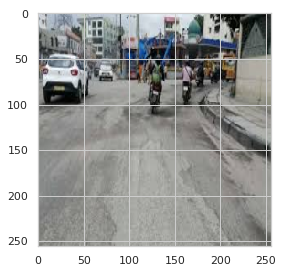

 50%|█████     | 4/8 [00:01<00:01,  3.51it/s]

Pothole Road


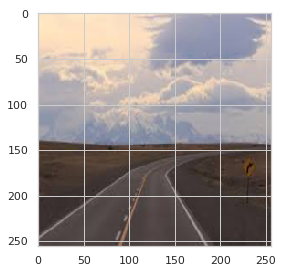

 62%|██████▎   | 5/8 [00:01<00:00,  3.89it/s]

Plain Road


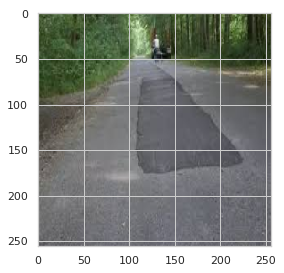

 75%|███████▌  | 6/8 [00:01<00:00,  4.12it/s]

Plain Road


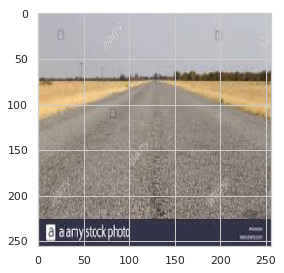

 88%|████████▊ | 7/8 [00:01<00:00,  4.41it/s]

Plain Road


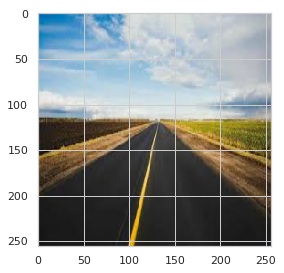

100%|██████████| 8/8 [00:01<00:00,  4.10it/s]

Plain Road


In [ ]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1]) 
    plt.show()  

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Plain Road")
    else:
        print("Pothole Road")

### Loading the model

In [ ]:
History = tf.keras.models.load_model('A:/TechieYan projects/AI/Pothole_using_resnet50/model/model.h5')

In [ ]:
score, acc = History.evaluate(x_test, y_test)
score, acc